## Spatial receptive fields in the ventral stream##

I want to get a clear image in my mind of the spatial sampling of an image at each stage of the ventral stream, this comes down to the shape of receptive fields and the number of receptive fields, as a function of eccentricity and angle in the visual field. 

### Visual Space###

Degrees visual angle is defined for a given extent of visual space as the angle that extent makes with respect to the focal point on the lens of the eye. 

$$V = 2\arctan(\frac{S}{2D})$$

where S is the extent of the stimulus, D is the distance to the stimulus (in the same units as S), and V is the degree visual angle of that stimulus. Given V we can learn the extent of that stimulus on the retina:

$$R = \nu \tan(V)$$

where $\nu \approx 17 mm$

and the total degrees visual angle is roughly $160$

### Cones###

A major prior on the visual system is the spatial sampling in the retina. Higher visual frequencies are more discriminable in the fovea then in the periphery. But by how much?

Here we will use data from : The Distribution of Cones in the Primate Retina. 1990. Digitized from Figure 2. https://www.ncbi.nlm.nih.gov/books/NBK235556/figure/mmm00055/?report=objectonly

Looking at the temporal horizontal meridian. I believe this is between the fovea and the ear.

Exponent= [-0.61]
Multiplier= [4.75]


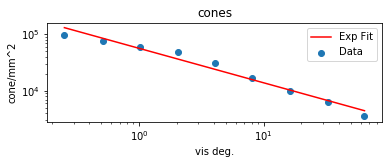

In [235]:
import csv
with open("cones_mm2_dg.csv") as f:
    reader = csv.reader(f)
    next(reader) # skip header
    data = np.array([[np.double(r[0]), np.double(r[1])] for r in reader])
cones = data

lcx = (np.log10(cones[:,0]));
lcy = (np.log10(cones[:,1]))[:, np.newaxis];

plt.subplot(211)
plt.title('cones')

A = np.vstack([lcx, np.ones(len(lcx))]).T;
m, c = np.linalg.lstsq(A , lcy, rcond=None)[0];
plt.loglog(10**(lcx), 10**(m*lcx + c), color='r');
plt.scatter(cones[:,0], cones[:,1]);

print('Exponent= ' + str(np.round(m,2)))
print('Multiplier= ' + str(np.round(c,2)))
plt.xlabel('vis deg.');plt.ylabel('cone/mm^2');
plt.legend(['Exp Fit', 'Data']);

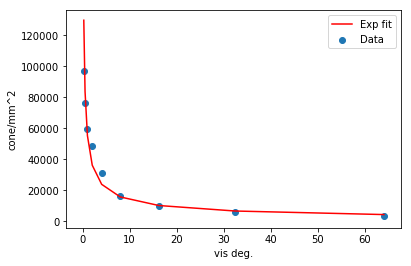

In [236]:
plt.plot(cones[:,0], 10**(m*lcx + c), color='r')
plt.scatter(cones[:,0], cones[:,1])
plt.xlabel('vis deg.');plt.ylabel('cone/mm^2');
plt.legend(['Exp fit', 'Data'])

So we now have an approximate formula for number of cones/mm^2 as a function of eccentricity. Can we get this to be a function of visual angle? 

Well if we take the square root of cones/mm^2 we get how many cones on the side of a unit square containing all those cones. 

Which is essentially if we draw a line from the fovea radiating outward on a given section of the line a mm long how many cones do we expect.  

Now to convert from mm on the retina to degrees visual angle we ask how many mm/v. deg are there?
Since 
$$R = \nu \tan(V)$$
then for 1 mm there are:
$$V = \arctan(1/\nu)$$

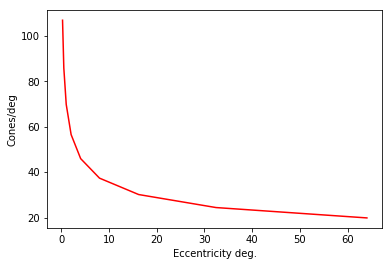

In [234]:
nu=17
old_y = 10**(m*lcx + c);
new_y = np.sqrt(old_y);
degpmm = np.rad2deg(np.arctan(1/nu))
new_y = new_y/degpmm;

plt.plot(cones[:,0], new_y, color='r');
plt.ylabel('Cones/deg');
plt.xlabel('Eccentricity deg.');

For scale 1 degree is about the size of the nail of your index finger with your arm outstretched. So on your fingernail are a 100X100 grid of cones with a nyquist frequency of 1/50 cycles/deg vis angle.

In V4 experiments typically the stimuli is scaled to the receptive field, where receptive fields are in turn a function of eccentricity, stimuli being place from 0 to 6 deg from RF center.

$$RF_{V4} =1^\circ + 0.625 * Ecc.$$

So at 6 deg the RF is ~5 degrees visual angle and the shape is made 3/4 of that size 3.75 degrees. Which means a sampling of 112 cones on each side. Close to what we would expect for looking at a 1 deg item at the center of vision.

In [189]:
# lets assume the distance to the screen in cm:
d = 50 
#the size of the stimuli on the screen in cm:
s = 5

#the d. vis ang of the stimuli is then:
v = 2*np.arctan(s/(2*d))

#the eccentricity in degrees
ecc = 10

cmm2 = 10**(m*np.log(ecc) + c)
cmm = cmm2**0.5

print(cmm)
print(cmm2)


[47.10823784]
[2219.18607228]


### The retino-cortico transform###

Retinal gangnlion packing density ($\rho_R$ cells per unit retinal area):
$$\rho_R = (w_0 + \epsilon r_R)^{-2}$$

$w_0 = 0.087$

$\epsilon = 0.051 $

$r_R = $ radius from fovea degrees visual angle  


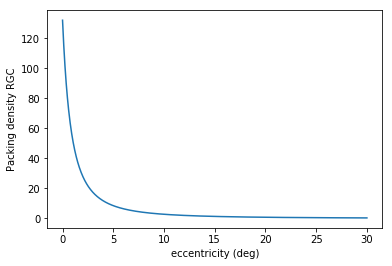

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

w_0 = 0.087
eps = 0.051
r = np.linspace(0, 30, 1000)

rho = (w_0 + eps*r)**(-2)

plt.plot(r, rho);
plt.xlabel('eccentricity (deg)');
plt.ylabel('Packing density RGC');

### Cortical receptive fields###

To a first approximation ($r=$ RF width and $e = $ eccentricity both in visual degrees)
V1

$r = 1 + 0.16e$

V2

$r = 2 + 0.4e$

V3 

Essen 1987 says 1.26 + 0.18e but they say in the same study V3 was larger than V2? 
Lets just put it between V2 and V4

$r = 2.5 + 0.575e$

V4

$r =  3 + 0.75e$

So to a first approximation we see a slowing rate of increase in RF size. 

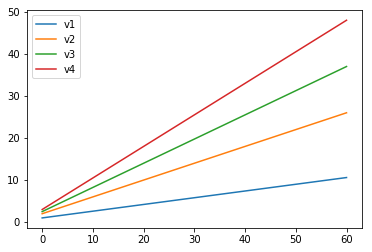

In [6]:
rfs = [0.16, 0.4, .575, .75]
offsets = [1, 2, 2.5, 3]

ecc = np.linspace(0,60,100)
for scale, shift in zip(rfs, offsets):
    plt.plot(ecc, ecc*scale+shift)

plt.legend(['v1', 'v2', 'v3', 'v4'])

In [9]:
rfs = np.array(rfs)[:, np.newaxis].T
ratios = rfs/rfs.T
print(np.round(ratios,2))

[[[[ 1.    2.5   3.59  4.69]]]


 [[[ 0.4   1.    1.44  1.88]]]


 [[[ 0.28  0.7   1.    1.3 ]]]


 [[[ 0.21  0.53  0.77  1.  ]]]]


We can conclude from this that we can fit roughly 5 V1 receptive fields (given eccentricity at the center of the rf) end to end across a V4 receptive field, 3.6 into a V3, 2.5 into a V2. But beyond that there cannot be two RFs non-overlapping from V2 onward feeding into something upstream, so heavy overlap is the norm. So if I put in two well seperated stimuli in a single RF they might interact with two relatively independent V1 units but they will likely be under the umbrella of single feedforward input RF's thus will most likely interact at earlier stages of the hiearchy.

We can caveat this with the fact that RF's are large and so are extending into more foveal regions where RF's will be smaller. 